In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np
from gensim.models import Word2Vec
import dgl
import dgl.nn as gnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy
import copy
import random as rd

Using backend: pytorch


## Simulated_annealing

### Генерация рандомного графа

In [2]:
def generate_graph(n, p):
    
    """ Функция генерирует рандомный граф c рандомными весами на ребрах
    
    n - количество вершин
    p - вероятность соединения ребер между узлами"""
    
    g1 = nx.gnp_random_graph(n, p)
    nx.draw(g1, pos = nx.spring_layout(g1), with_labels = True)
    
    #===================create dgl graph from networkx=====================================
    g = dgl.from_networkx(g1)
    valume1 = g.edges()[0 ].tolist()
    valume2 = g.edges()[1].tolist()
    data = np.array([valume1, valume2]).T
    data_edges = pd.DataFrame(data=data)
    weights = np.random.randint(0, 40, len(data_edges)).tolist()
    
    #====================this is necessary for the same edges to be equal===================
    for i in range(len(data_edges)):
        x = np.random.randint(0, 40, 1)[0]
        edge = (data_edges[0][i], data_edges[1][i])
        for j in range(len(data_edges[1])):
            if edge == (data_edges[1][j], data_edges[0][j]):
                weights[j] = weights[i] 
    data_edges['weights'] = weights
    
    #=====================append weights to edges============================================
    g.edata['weights'] = torch.tensor(weights,  dtype=torch.int32)
    return g

### Пример использования

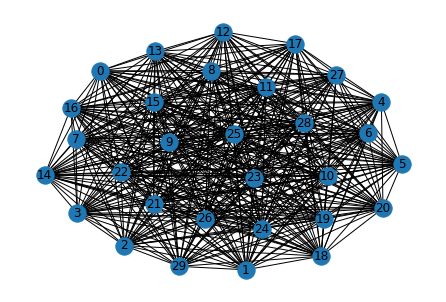

In [3]:
num_nodes = 30
g = generate_graph(num_nodes, 1)

In [4]:
def count_distance(S0):
    
    """ Функция считает рандомный путь
    
    S0 - рандомный путь"""
    
    L = 0
    for i in range(len(S0)-1):
        L+= g.edata['weights'][S0[i+1]]
    return L


def generate_prob_path(path):
    
    """ Функция генерирует рандомный путь
    
    path - рандомный путь"""
        
    len_path = len(path)
    first_city_idx = np.random.randint(0, len_path-1)
    second_city_idx = np.random.randint(0, len_path-1)
    if first_city_idx > second_city_idx:
        first_city_idx, second_city_idx = second_city_idx, first_city_idx
    new_route = copy.copy(path)
    new_route[first_city_idx : second_city_idx] = reversed(new_route[first_city_idx : second_city_idx]) 
    return new_route

def probability(difference, temperature):
    """ Функция считает вероятность перехода в другую вершину
    
    difference - разница между весом возможного и настоящего пути
    temperature - температура"""
    
    return np.e**(-difference/temperature)

def temp_reduction(T0, k, current_k):
    """ Функция для понижения температуры
    
    T0 - начальная температура
    k - количество итераций
    current_k - текущая итерация"""
    
    return T0 * (1 - current_k/k)

In [5]:
def simulated_annealing(path, k, T0):
    
    """ Функция для реализации алгоритма имитации отжига (simulated_annealing)
    path - рандомный путь
    k - количество итераций
    T0 - начальная температура"""
        
    cur_route_dist = path
    process = []
    
    for cur_iter in range(k):
        
        #===========================генерируем путь==========================================
        prob_path = generate_prob_path(path)
        current_path = path
        
        #============================count current and random meanings=======================
        cur_route_dist = count_distance(current_path)
        candidate_dist = count_distance(prob_path)
        
        process.append(cur_route_dist)
        #if current path longer
        if cur_route_dist > candidate_dist:
            
            #====================================переходим в рандомный узел=========================================
            path = prob_path
            cur_route_fitness = current_path
        else:
            
            #====================================count temperature================================================
            cur_iter_temp = temp_reduction(T0, k, cur_iter)
            func_val_diff = candidate_dist - cur_route_dist
            
            #====================================вероятность перехода в новое состояние, которое хуже по дистанции==========
            random_val = np.random.uniform(0, 1)
            cur_iter_transition_prob = probability(func_val_diff, cur_iter_temp)
            
            #====================================переходим в зависимости от случайной величины============================
            if random_val <= cur_iter_transition_prob:
                path = prob_path
                cur_route_fitness = current_path
                
   
    fig = plt.figure(figsize=(5,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.plot(process)
    plt.title('Dependence of distance from interation')
    plt.xlabel('Number of iteretion')
    plt.ylabel('Distance');
    
    return path

### Пример использования

path:[19, 28, 4, 7, 18, 0, 22, 15, 14, 20, 23, 2, 25, 8, 13, 1, 17, 5, 10, 26, 16, 6, 3, 29, 27, 24, 12, 21, 11, 9]
 стоимость пути: 662


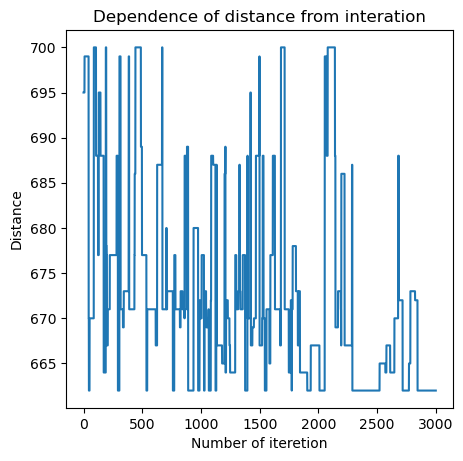

In [6]:
# generate random path
S0 = np.random.permutation(num_nodes).tolist()
# Гиперпараметры
k = 3000
T0 = 100
S = simulated_annealing(S0, k, T0)
print(f'path:{S}')
print(f' стоимость пути: {count_distance(S)}')

## Алгоритм муравьиной колонии (ACO)

### Генерация рандомного графа

In [7]:
def generate_graph(n, p):
    
    """ Функция генерирует рандомный граф c рандомными весами на ребрах
    
    n - количество вершин
    p - вероятность соединения ребер между узлами"""
    
    g1 = nx.gnp_random_graph(n, p)
    nx.draw(g1, pos = nx.spring_layout(g1), with_labels = True)
    
    # ============create dgl graph from networkx============
    g = dgl.from_networkx(g1)
    valume1 = g.edges()[0 ].tolist()
    valume2 = g.edges()[1].tolist()
    data = np.array([valume1, valume2]).T
    data_edges = pd.DataFrame(data=data)
    weights = np.random.randint(6, 40, len(data_edges)).tolist()
    pheromones = np.random.randint(1, 5, len(data_edges)).tolist()
    
    # ============this is necessary for the same edges to be equal============
    for i in range(len(data_edges)):
        x = np.random.randint(0, 40, 1)[0]
        edge = (data_edges[0][i], data_edges[1][i])
        for j in range(len(data_edges[1])):
            if edge == (data_edges[1][j], data_edges[0][j]):
                weights[j] = weights[i] 
    data_edges['weights'] = weights
    data_edges['pheromones'] = pheromones
    
    # ============append weights to edges and to nodes========================
    g.edata['weights'] = torch.tensor(weights,  dtype=torch.int32)
    g.edata['pheromones'] = torch.tensor(pheromones,  dtype=torch.int32)
    num_hills = num_nodes
    ant_path = np.zeros((num_hills, num_nodes)).astype(int) - 1
    pheromones = np.ones((num_hills, num_nodes)).astype(int) 
    pheromone_weights = np.zeros((len(g.edata['pheromones']), 1)).astype(int)
    g.edata['pheromone_weights'] =  torch.tensor(pheromone_weights,  dtype=torch.float32)
    g.ndata['pheromones'] = torch.tensor(pheromones,  dtype=torch.float32)
    
    #============append path matrix to edges==================================
    g.ndata['ant_path'] = torch.tensor(ant_path,  dtype=torch.int32)
    
    #=============матрица для весов дорог=====================================
    weights_nodes = np.zeros((num_hills, num_nodes)).astype(int)
    
    #=============заполняем рандомными весами==================================
    for i in range(len(weights_nodes[0])):
        for j in range(len(weights_nodes)):
            if i == j:
                weights_nodes[i, j] = 0
            else:
                x = np.random.randint(1, 100, 1)
                weights_nodes[i, j], weights_nodes[j, i] = x, x

    g.ndata['weighted_nodes'] = torch.tensor(weights_nodes, dtype = torch.int32)
    return g

### Пример использования

Graph(num_nodes=10, num_edges=90,
      ndata_schemes={'pheromones': Scheme(shape=(10,), dtype=torch.float32), 'ant_path': Scheme(shape=(10,), dtype=torch.int32), 'weighted_nodes': Scheme(shape=(10,), dtype=torch.int32)}
      edata_schemes={'weights': Scheme(shape=(), dtype=torch.int32), 'pheromones': Scheme(shape=(), dtype=torch.int32), 'pheromone_weights': Scheme(shape=(1,), dtype=torch.float32)})

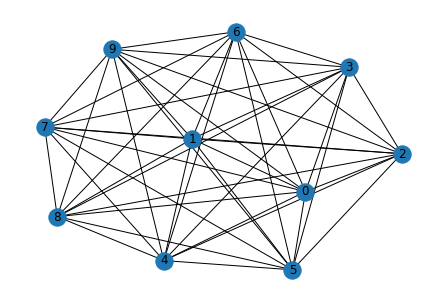

In [8]:
num_nodes = 10
g = generate_graph(num_nodes, 1)
g

In [13]:
# ===========count distance of path=================
def distance(g):
    """ Функция считает вес пути
    
    g - граф"""
    length =[]
    dis = 0
    for i in range(len(g.ndata['ant_path'])):
        for j in range(len(g.ndata['ant_path'][i]) - 1):
            dis += g.ndata['weighted_nodes'][g.ndata['ant_path'][i][j]][g.ndata['ant_path'][i][j + 1]].tolist()
        dis += g.ndata['weighted_nodes'][g.ndata['ant_path'][i][-1]][g.ndata['ant_path'][i][0]].tolist()
        length.append(dis)
        dis = 0
    return length

In [14]:
def ACO(g):
    """ Функция выполняет реализацию муравьиного алгоритма(ACO)
    
    g - граф"""
    
    for epoch in range(epochs):
        g.ndata['ant_path'] = torch.tensor(ant_path,  dtype=torch.int32)   
        firstnode = [i for i in range(num_nodes)]
        rd.shuffle(firstnode)         
        tabu = []
        p = []
        P = 0
        
        #==============добавление узла в матрицу узлов==========================
        for i in range(len(g.ndata['ant_path'].tolist())):
            g.ndata['ant_path'][i][0] = firstnode[i]
        for i in range(len(g.ndata['ant_path'][0].tolist()) - 1):       
            for j in range(len(g.ndata['ant_path'].tolist())):
                for k in range(num_nodes):
                    if k not in g.ndata['ant_path'][j].tolist():
                        tabu.append(k)
                for node1 in tabu:
                    P += g.ndata['pheromones'][g.ndata['ant_path'][j][i].tolist()][node1] ** alpha * (1/g.ndata['weighted_nodes'][g.ndata['ant_path'][j][i].tolist()][node1]) ** beta
                for node2 in tabu:
                    p.append(g.ndata['pheromones'][g.ndata['ant_path'][j][i].tolist()][node2] ** alpha * (1/g.ndata['weighted_nodes'][g.ndata['ant_path'][j][i].tolist()][node2]) ** beta / P)
                rand = np.array(p).cumsum()             
                r = rd.uniform(min(rand), max(rand))
                for x in range(len(rand)):
                    if rand[x] >= r:                  
                        g.ndata['ant_path'][j][i + 1] = tabu[x]
                        break
                tabu = []
                p = []
                P = 0
                
        #===================обновляем феромоны============================================
        g.ndata['pheromones'] = (1 - learn_rate)*g.ndata['pheromones']          
        length = distance(g)
        for i in range(len(g.ndata['ant_path'].tolist())):
            for j in range(len(g.ndata['ant_path'].tolist()[i]) - 1):
                g.ndata['pheromones'][g.ndata['ant_path'][i][j].tolist()][g.ndata['ant_path'][i][j + 1].tolist()] += 1 / length[i]     # Обновление феромона
            g.ndata['pheromones'][g.ndata['ant_path'][i][-1].tolist()][g.ndata['ant_path'][i][0].tolist()] += 1 / length[i]
            
    min_path = g.ndata["ant_path"].tolist()[length.index(min(length))] 
    min_dist = min(length)
    return min_path, min_dist

### Пример использования

In [17]:
# Гиперпараметры         
alpha = 1                 
beta = 3                     
learn_rate = 0.3  
num_hills = num_nodes
num_nodes = 10
epochs = 100
ant_path = np.zeros((num_hills, num_nodes)).astype(int) - 1
min_path, min_dist = ACO(g) 
print(f' Кратчайший путь: {min_path}')    
print(f' Наименьшая дистанция: {min_dist}')

 Кратчайший путь: [2, 3, 8, 9, 1, 5, 7, 6, 4, 0]
 Наименьшая дистанция: 198
